In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Fri Feb 18 08:00:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
#from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [256, 256]

train_path = '/content/drive/MyDrive/Datasets/PlantVillage/train'
valid_path = '/content/drive/MyDrive/Datasets/PlantVillage/val'

In [ ]:
base = DenseNet201(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
base.output

74850304/74836368 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 8, 8, 1920) dtype=float32 (created by layer 'relu')>

In [ ]:
for layer in base.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base.output)
x=Dropout(0.5)(x)

In [ ]:
prediction = Dense(38, activation='softmax')(x)

# create a model object
model = Model(inputs=base.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers

model.compile (loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics=['acc',tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 43444 images belonging to 38 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 10871 images belonging to 38 classes.


In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=25)

Epoch 1/25
1358/1358 [==============================] - 16608s 12s/step - loss: 3.0074 - acc: 0.4315 - true_positives: 16578.0000 - true_negatives: 1592162.0000 - false_positives: 15266.0000 - false_negatives: 26866.0000 - precision: 0.5206 - recall: 0.3816 - val_loss: 128.2554 - val_acc: 0.0387 - val_true_positives: 420.0000 - val_true_negatives: 391794.0000 - val_false_positives: 10433.0000 - val_false_negatives: 10451.0000 - val_precision: 0.0387 - val_recall: 0.0386
Epoch 2/25
1358/1358 [==============================] - 809s 596ms/step - loss: 2.7111 - acc: 0.5351 - true_positives: 22314.0000 - true_negatives: 1591049.0000 - false_positives: 16379.0000 - false_negatives: 21130.0000 - precision: 0.5767 - recall: 0.5136 - val_loss: 197.2184 - val_acc: 0.0247 - val_true_positives: 269.0000 - val_true_negatives: 391625.0000 - val_false_positives: 10602.0000 - val_false_negatives: 10602.0000 - val_precision: 0.0247 - val_recall: 0.0247
Epoch 3/25
1358/1358 [============================

In [ ]:
from tensorflow.keras.models import load_model

model.save('densenet201_multi.h5')

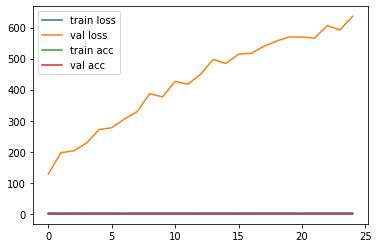

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
test_dir = '/content/drive/MyDrive/Datasets/PlantVillage/val'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory (
                test_dir,
                target_size=(256,256),
                batch_size=32,
                class_mode="categorical")

Found 10871 images belonging to 38 classes.


In [ ]:
model.evaluate(test_generator)

340/340 [==============================] - 67s 196ms/step - loss: 636.3026 - acc: 0.0339 - true_positives: 368.0000 - true_negatives: 391725.0000 - false_positives: 10502.0000 - false_negatives: 10503.0000 - precision: 0.0339 - recall: 0.0339


[636.3026123046875,
 0.03385153040289879,
 368.0,
 391725.0,
 10502.0,
 10503.0,
 0.0338546447455883,
 0.03385153040289879]